In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit as logistic
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

/home/osvaldo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Code 10.1

In [2]:
d = pd.read_csv('Data/chimpanzees.csv', sep=";")
# we change "actor" to zero-index
d.actor = d.actor - 1

#### Code 10.2

In [3]:
with pm.Model() as model_10_1:
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    p = pm.math.invlogit(a)    
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bp, a]
100%|██████████| 2000/2000 [00:02<00:00, 767.57it/s]


In [4]:
df_10_1 = pm.summary(trace_10_1, alpha=.11)
df_10_1.round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.33,0.09,0.00,0.18,0.47,2125.71,1.0
bp,-0.20,10.05,0.21,-17.31,15.25,2260.01,1.0


#### Code 10.3

In [5]:
logistic(df_10_1.iloc[:,3:5]).round(5)

,hpd_5.5,hpd_94.5
a,0.54609,0.61615
bp,0.00000,1.00000


#### Code 10.4

In [6]:
with pm.Model() as model_10_2:
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    p = pm.math.invlogit(a + bp * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_2 = pm.sample(1000, tune=1000)

with pm.Model() as model_10_3:
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    p = pm.math.invlogit(a + (bp + bpC * d.condition) * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bp, a]
100%|██████████| 2000/2000 [00:03<00:00, 552.42it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bpC, bp, a]
100%|██████████| 2000/2000 [00:05<00:00, 359.68it/s]


#### Code 10.5

In [7]:
comp_df = pm.compare({model_10_1 : trace_10_1,
                      model_10_2 : trace_10_2,
                      model_10_3 : trace_10_3},
                     method='pseudo-BMA')

comp_df.loc[:,'model'] = pd.Series(['m10.1', 'm10.2', 'm10.3'])
comp_df = comp_df.set_index('model')
comp_df

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m10.2,680.57,2.04,0,0.73,9.27,0,0
m10.3,682.7,3.18,2.13,0.25,9.46,0.83,0
m10.1,687.94,1,7.37,0.02,7.25,6.13,0


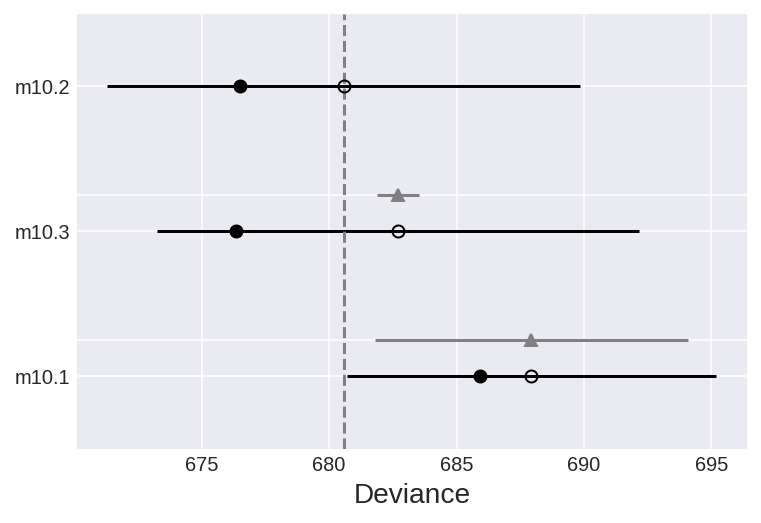

In [8]:
pm.compareplot(comp_df);

#### Code 10.6

In [9]:
pm.summary(trace_10_3, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.05,0.13,0.00,-0.15,0.25,1305.26,1.0
bp,0.61,0.23,0.01,0.27,0.99,1264.87,1.0
bpC,-0.11,0.27,0.01,-0.58,0.30,1374.49,1.0


#### Code 10.7

In [10]:
np.exp(0.61)

1.8404313987816374

#### Code 10.8

In [11]:
logistic(4)

0.9820137900379085

#### Code 10.9

In [12]:
logistic(4 + 0.61)

0.9901462444767687

#### Code 10.10 and 10.11

In [13]:
d_pred = pd.DataFrame({'prosoc_left' : [0, 1, 0, 1], 'condition' : [0, 0, 1, 1]})
traces = [trace_10_1, trace_10_2, trace_10_3]
models = [model_10_1, model_10_2, model_10_3]


chimp_ensemble = pm.sample_ppc_w(traces=traces, models=models, samples=1000, 
                                 weights=comp_df.weight.sort_index(ascending=True))

100%|██████████| 1000/1000 [00:00<00:00, 1674.06it/s]


In [14]:
rt = chimp_ensemble['pulled_left']
pred_mean = np.zeros((1000, 4))
cond = d.condition.unique()
prosoc_l = d.prosoc_left.unique()
for i in range(len(rt)):
    tmp = []
    for cp in cond:
        for pl in prosoc_l:
            tmp.append(np.mean(rt[i][(d.prosoc_left==pl) & (d.chose_prosoc==cp)]))
    pred_mean[i] = tmp
    
ticks = range(4)
mp = pred_mean.mean(0)
hpd = pm.hpd(pred_mean)
plt.fill_between(ticks, hpd[:,1], hpd[:,0], alpha=0.25, color='k')
plt.plot(mp, color='k')
plt.xticks(ticks, ("0/0","1/0","0/1","1/1"))
chimps = d.groupby(['actor', 'prosoc_left', 'condition']).agg('mean')['pulled_left'].values.reshape(7, -1)
for i in range(7):
    plt.plot(chimps[i], 'C0')

plt.ylim(0, 1.1);

IndexError: too many indices for array

#### Code 10.12 & 10.13
This is the same as 10.6, but in the book using MCMC rather than quadratic approximation.

#### Code 10.14

In [ ]:
with pm.Model() as model_10_4:
    a = pm.Normal('alpha', 0, 10, shape=len(d.actor.unique()))
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    p = pm.math.invlogit(a[d.actor.values] + (bp + bpC * d.condition) * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_4 = pm.sample(1000, tune=1000)

#### Code 10.15

In [ ]:
# remember we use a zero-index
d['actor'].unique()

#### Code 10.16

In [ ]:
pm.summary(trace_10_4, alpha=.11).round(2)

#### Code 10.17

In [ ]:
post = pm.trace_to_dataframe(trace_10_4)
post.head()

#### Code 10.18

In [ ]:
pm.kdeplot(post['alpha__1']);

#### Code 10.19

In [ ]:
rt = pm.sample_ppc(trace_10_4, 1000, model_10_4)['pulled_left']

In [ ]:
chimp = 2
pred_mean = np.zeros((1000, 4))
cond = d.condition.unique()
prosoc_l = d.prosoc_left.unique()
for i in range(len(rt)):
    tmp = []
    for cp in cond:
        for pl in prosoc_l:
            tmp.append(np.mean(rt[i][(d.prosoc_left == pl) & (d.chose_prosoc == cp) & (d.actor == chimp)]))
    pred_mean[i] = tmp

ticks = range(4)
mp = pred_mean.mean(0)
hpd = pm.hpd(pred_mean, alpha=0.11)
plt.fill_between(ticks, hpd[:,1], hpd[:,0], alpha=0.25, color='k')
plt.plot(mp, color='k')
plt.xticks(ticks, ("0/0","1/0","0/1","1/1"))
chimps = d[d.actor == chimp].groupby(['condition', 'prosoc_left', ]).agg('mean')['pulled_left'].values
plt.plot(chimps, 'C0')

plt.ylim(0, 1.1);

#### Code 10.20

In [ ]:
d_aggregated = d.groupby(['actor', 'condition', 'prosoc_left',  ])['pulled_left'].sum().reset_index()
d_aggregated.head(8)

#### Code 10.21

In [ ]:
with pm.Model() as model_10_5:
    a = pm.Normal('alpha', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    p = pm.math.invlogit(a + (bp + bpC * d_aggregated.condition) * d_aggregated.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 18, p, observed=d_aggregated.pulled_left)

    trace_10_5 = pm.sample(1000, tune=1000)

In [ ]:
pm.summary(trace_10_5, alpha=.11).round(2)

In [ ]:
# hacky check of similarity to 10_3, within a hundreth
np.isclose(pm.summary(trace_10_5), pm.summary(trace_10_3), atol=0.01)

#### Code 10.22

In [ ]:
d_ad = pd.read_csv('./Data/UCBadmit.csv', sep=';')
d_ad.head(8)

#### Code 10.23

In [ ]:
d_ad['male'] = (d_ad['applicant.gender'] == 'male').astype(int)

with pm.Model() as model_10_6:
    a = pm.Normal('a', 0, 10)
    bm = pm.Normal('bm', 0, 10)
    p = pm.math.invlogit(a + bm * d_ad.male)
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_10_6 = pm.sample(1000, tune=1000)
    
with pm.Model() as model_10_7:
    a = pm.Normal('a', 0, 10)
    p = pm.math.invlogit(a)
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_10_7 = pm.sample(1000, tune=1000)

#### Code 10.24

In [ ]:
# Something goofy here... 
# not even close to WAIC values, larger standard error

comp_df = pm.compare({model_10_6 : trace_10_6
                      model_10_7 : trace_10_7})

comp_df.loc[:,'model'] = pd.Series(['m10.6', 'm10.7'])
comp_df = comp_df.set_index('model')
comp_df

#### Code 10.25

In [ ]:
pm.summary(trace_10_6, alpha=.11).round(2)

#### Code 10.26

In [ ]:
post = pm.trace_to_dataframe(trace_10_6)
p_admit_male = logistic(post['a'] + post['bm'])
p_admit_female = logistic(post['a'])
diff_admit = p_admit_male - p_admit_female
diff_admit.describe(percentiles=[.025, .5, .975])[['2.5%', '50%', '97.5%']]

#### Code 10.27

In [ ]:
for i in range(6):
    x = 1 + 2 * i
    y1 = d_ad.admit[x] / d_ad.applications[x]
    y2 = d_ad.admit[x+1] / d_ad.applications[x+1]
    plt.plot([x, x+1], [y1, y2], '-C0o', lw=2)
    plt.text(x + 0.25, (y1+y2)/2 + 0.05, d_ad.dept[x])
plt.ylim(0, 1);

#### Code 10.28

In [ ]:
d_ad['dept_id'] = pd.Categorical(d_ad['dept']).codes

In [ ]:
with pm.Model() as model_10_8:
    a = pm.Normal('a', 0, 10, shape=len(d_ad['dept'].unique()))
    p = pm.math.invlogit(a[d_ad['dept_id'].values])
    admit = pm.Binomial('admit', p=p, n=d_ad['applications'], observed=d_ad['admit'])
    
    trace_10_8 = pm.sample(1000, tune=1000)

with pm.Model() as model_10_9:
    a = pm.Normal('a', 0, 10, shape=len(d_ad['dept'].unique()))
    bm = pm.Normal('bm', 0, 10)
    p = pm.math.invlogit(a[d_ad['dept_id'].values] + bm * d_ad['male'])
    admit = pm.Binomial('admit', p=p, n=d_ad['applications'], observed=d_ad['admit'])
    
    trace_10_9 = pm.sample(1000, tune=1000)

#### Code 10.29

In [ ]:
# WAIC values still off
# Plus warning flag

comp_df = pm.compare({model_10_6 : trace_10_6,
                      model_10_7 : trace_10_7,
                      model_10_8 : trace_10_8,
                      model_10_9 : trace_10_9},
                     method='pseudo-BMA')

comp_df.loc[:,'model'] = pd.Series(['m10.6', 'm10.7', 'm10.8', 'm10.9'])
comp_df = comp_df.set_index('model')
comp_df

#### Code 10.30

In [ ]:
pm.summary(trace_10_9, alpha=.11).round(2)

#### Code 10.31
Replicated model above but with MCMC in book.

#### Code 10.32

In [ ]:
import statsmodels.api as sm
from patsy import dmatrix

endog = d_ad.loc[:,['admit', 'reject']].values # cbind(admit,reject)

m10_7glm = sm.GLM(endog, dmatrix('~ 1', data=d_ad), 
                  family=sm.families.Binomial())
m10_6glm = sm.GLM(endog, dmatrix('~ male', data=d_ad), 
                  family=sm.families.Binomial())
m10_8glm = sm.GLM(endog, dmatrix('~ dept_id', data=d_ad), 
                  family=sm.families.Binomial())
m10_9glm = sm.GLM(endog, dmatrix('~ male + dept_id', data=d_ad), 
                  family=sm.families.Binomial())
# res = m10_7glm.fit()
# res.summary()

#### Code 10.33

In [ ]:
import statsmodels.formula.api as smf
m10_4glm = smf.glm(formula='pulled_left ~ actor + prosoc_left*condition - condition', data=d, 
                   family=sm.families.Binomial())

#### Code 10.34

In [ ]:
pm.GLM.from_formula('pulled_left ~ actor + prosoc_left*condition - condition', 
                    family='binomial', data=d)   

#### Code 10.35

In [ ]:
# outcome and predictor almost perfectly associated
y = np.hstack([np.ones(10,)*0, np.ones(10,)])
x = np.hstack([np.ones(9,)*-1, np.ones(11,)])

m_bad = smf.glm(formula='y ~ x', 
                data=pd.DataFrame({'y':y, 'x':x}), 
                family=sm.families.Binomial()).fit()
m_bad.summary()

#### Code 10.36

In [ ]:
with pm.Model() as m_good:
    ab = pm.Normal('ab', 0, 10, shape=2)
    p = pm.math.invlogit(ab[0] + ab[1]*x)
    y_ = pm.Binomial('y_', 1, p, observed=y)
    
    MAP = pm.find_MAP()
MAP

#### Code 10.37

In [ ]:
trace = pm.sample(1000, tune=1000, model=m_good)
tracedf = pm.trace_to_dataframe(trace)
grid = (sns.PairGrid(tracedf,
                     diag_sharey=False)
           .map_diag(sns.kdeplot)
           .map_upper(plt.scatter, alpha=0.1))

#### Code 10.38

In [ ]:
y = stats.binom.rvs(n=1000, p=1/1000, size=100000)
np.mean(y), np.var(y)

#### Code 10.39

In [ ]:
dk = pd.read_csv('Data/Kline', sep=';')
dk

#### Code 10.40

In [ ]:
dk.log_pop = np.log(dk.population)
dk.contact_high = (dk.contact == "high").astype(int)

In [ ]:
from theano import shared
# casting data to theano shared variable. 
# It is for out of sample prediction from model with sampled trace
log_pop = shared(dk.log_pop.values)
contact_high = shared(dk.contact_high.values)
total_tools = shared(dk.total_tools.values)

#### Code 10.41

In [ ]:
with pm.Model() as m_10_10:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1, shape=3)
    lam = pm.math.exp(a + b[0] * log_pop + b[1] * contact_high + b[2] * contact_high * log_pop)
    obs = pm.Poisson('total_tools', lam, observed=total_tools)
    trace_10_10 = pm.sample(1000, tune=1000)

#### Code 10.42

In [ ]:
summary = pm.summary(trace_10_10, alpha=.11)[['mean', 'sd', 'hpd_5.5', 'hpd_94.5']]
trace_cov = pm.trace_cov(trace_10_10, model=m_10_10)
invD = (np.sqrt(np.diag(trace_cov))**-1)[:, None]
trace_corr = pd.DataFrame(invD*trace_cov*invD.T, index=summary.index, columns=summary.index)

summary.join(trace_corr).round(2)

In [ ]:
pm.forestplot(trace_10_10);

#### Code 10.43

In [ ]:
lambda_high = np.exp(trace_10_10['a'] + trace_10_10['b'][:,1] + (trace_10_10['b'][:,0] + trace_10_10['b'][:,2]) * 8)
lambda_low = np.exp(trace_10_10['a'] + trace_10_10['b'][:,0] * 8 )

#### Code 10.44

In [ ]:
diff = lambda_high - lambda_low
np.sum(diff > 0) / len(diff)

#### Code 10.45

In [ ]:
with pm.Model() as m_10_11:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1, shape=2)
    lam = pm.math.exp(a + b[0] * log_pop + b[1] * contact_high)
    obs = pm.Poisson('total_tools', lam, observed=total_tools)
    trace_10_11 = pm.sample(1000, tune=1000)

#### Code 10.46

In [ ]:
with pm.Model() as m_10_12:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1)
    lam = pm.math.exp(a + b * log_pop)
    obs = pm.Poisson('total_tools', lam, observed=total_tools)
    trace_10_12 = pm.sample(1000, tune=1000)
    
with pm.Model() as m_10_13:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1)
    lam = pm.math.exp(a + b * contact_high)
    obs = pm.Poisson('total_tools', lam, observed=total_tools)
    trace_10_13 = pm.sample(1000, tune=1000)



#### Code 10.47

In [ ]:
with pm.Model() as m_10_14:
    a = pm.Normal('a', 0, 100)
    lam = pm.math.exp(a)
    obs = pm.Poisson('total_tools', lam, observed=total_tools)
    trace_10_14 = pm.sample(1000, tune=1000)

In [ ]:
traces = [trace_10_10, trace_10_11, trace_10_12, trace_10_13, trace_10_14]
models = [m_10_10, m_10_11, m_10_12, m_10_13, m_10_14]

islands_compare = pm.compare(traces, models, method='pseudo-BMA')

islands_compare.loc[:,'model'] = pd.Series(['m10.10', 'm10.11', 'm10.12', 'm10.13', 'm10.14'])
islands_compare = islands_compare.set_index('model')
islands_compare

In [ ]:
pm.compareplot(islands_compare);

#### Code 10.48

In [ ]:
# set new value for out-of-sample prediction 
log_pop_seq = np.linspace(6, 13, 30)
log_pop.set_value(np.hstack([log_pop_seq, log_pop_seq]))
contact_high.set_value(np.hstack([np.repeat(0, 30), np.repeat(1, 30)]))

islands_ensemble = pm.sample_ppc_w(traces, 10000, 
                                   models, weights=islands_compare.weight.sort_index(ascending=True))

In [ ]:
_, axes = plt.subplots(1, 1, figsize=(5, 5))
index = dk.contact_high==1
axes.scatter(np.log(dk.population)[~index], dk.total_tools[~index],
             facecolors='none', edgecolors='k', lw=1)
axes.scatter(np.log(dk.population)[index], dk.total_tools[index])

mp = islands_ensemble['total_tools'][:, :30]
mu_hpd = pm.hpd(mp, alpha=.50)

axes.plot(log_pop_seq, np.median(mp, axis=0), '--', color='k')
axes.fill_between(log_pop_seq,
                  mu_hpd[:,0], mu_hpd[:,1], alpha=0.25, color='k')

mp = islands_ensemble['total_tools'][:, 30:]
mu_hpd = pm.hpd(mp, alpha=.50)

axes.plot(log_pop_seq, np.median(mp, axis=0))
axes.fill_between(log_pop_seq,
                  mu_hpd[:,0], mu_hpd[:,1], alpha=0.25)
axes.set_xlabel('log-population')
axes.set_ylabel('total tools')
axes.set_xlim(6.8, 12.8)
axes.set_ylim(10, 73);

#### Code 10.49
This is the same as 10.41, but in the book using MCMC rather than MAP.

In [ ]:
pm.summary(trace_10_10, alpha=.11).round(2)

#### Code 10.50

In [ ]:
log_pop_c = dk.log_pop.values - dk.log_pop.values.mean()
log_pop.set_value(log_pop_c)
contact_high.set_value(dk.contact_high.values)
total_tools.set_value(dk.total_tools.values)

with pm.Model() as m_10_10c:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1, shape=3)
    lam = pm.math.exp(a + b[0] * log_pop + b[1] * contact_high + b[2] * contact_high * log_pop)
    obs = pm.Poisson('total_tools', lam, observed=total_tools)
    trace_10_10c = pm.sample(1000, tune=1000)

In [ ]:
pm.summary(trace_10_10c, alpha=.11).round(2)

In [ ]:
for trace in [trace_10_10, trace_10_10c]:
    tracedf = pm.trace_to_dataframe(trace)
    grid = (sns.PairGrid(tracedf,
                         diag_sharey=False)
               .map_diag(sns.kdeplot)
               .map_upper(plt.scatter, alpha=0.1))

#### Code 10.51

In [ ]:
num_days = 30
y = np.random.poisson(1.5, num_days)

#### Code 10.52

In [ ]:
num_weeks = 4
y_new = np.random.poisson(0.5*7, num_weeks)

#### Code 10.53

In [ ]:
y_all = np.hstack([y, y_new])
exposure = np.hstack([np.repeat(1, 30), np.repeat(7, 4)]).astype('float')
monastery = np.hstack([np.repeat(0, 30), np.repeat(1, 4)])

#### Code 10.54

In [ ]:
log_days = np.log(exposure)
with pm.Model() as m_10_15:
    a = pm.Normal('a', 0., 100.)
    b = pm.Normal('b', 0., 1.)
    lam = pm.math.exp(log_days + a + b*monastery)
    obs = pm.Poisson('y', lam, observed=y_all)
    trace_10_15 = pm.sample(1000, tune=1000)

#### Code 10.55

In [ ]:
trace_10_15.add_values(dict(lambda_old=np.exp(trace_10_15['a']),
                            lambda_new=np.exp(trace_10_15['a'] + trace_10_15['b'])))

pm.summary(trace_10_15, varnames=['lambda_old', 'lambda_new'], alpha=.11).round(2)

#### Code 10.56

In [ ]:
# simulate career choices among 500 individuals
N = 500                 # number of individuals
income = np.arange(3)+1 # expected income of each career
score = 0.5*income      # scores for each career, based on income
# next line converts scores to probabilities
def softmax(w):
    e = np.exp(w)
    return e/np.sum(e, axis=0)

p = softmax(score)
# now simulate choice
# outcome career holds event type values, not counts
career = np.random.multinomial(1, p, size=N)
career = np.where(career==1)[1]

#### Code 10.57

In [ ]:
import theano.tensor as tt
with pm.Model() as m_10_16:
    b = pm.Normal('b', 0., 5.)
    s2 = b*2
    s3 = b*3
    p_ = tt.stack([b, s2, s3])
    obs = pm.Categorical('career', p=tt.nnet.softmax(p_), observed=career)
    trace_10_16 = pm.sample(1000, tune=1000)
pm.summary(trace_10_16, alpha=.11).round(2)

#### Code 10.58

In [ ]:
N = 100
# simulate family incomes for each individual
family_income = np.random.rand(N)
# assign a unique coefficient for each type of event
b = np.arange(3)-1
p = softmax(score[:, None] + np.outer(b, family_income)).T
career = np.asarray([np.random.multinomial(1, pp) for pp in p])
career = np.where(career==1)[1]

In [ ]:
with pm.Model() as m_10_17:
    a23 = pm.Normal('a23', 0, 5, shape=2)
    b23 = pm.Normal('b23', 0, 5, shape=2)
    s2 = a23[0] + b23[0]*family_income
    s3 = a23[1] + b23[1]*family_income
    p_ = tt.stack([np.zeros(N), s2, s3]).T
    obs = pm.Categorical('career', p=tt.nnet.softmax(p_), observed=career)
    trace_10_17 = pm.sample(1000, tune=1000)
pm.summary(trace_10_17, alpha=.11).round(2)

#### Code 10.59

In [ ]:
d_ad = pd.read_csv('./Data/UCBadmit.csv', sep=';')

#### Code 10.60

In [ ]:
# binomial model of overall admission probability
with pm.Model() as m_binom:
    a = pm.Normal('a', 0, 100)
    p = pm.math.invlogit(a)
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    trace_binom = pm.sample(1000, tune=1000)
    
# Poisson model of overall admission rate and rejection rate
with pm.Model() as m_pois:
    a = pm.Normal('a', 0, 100, shape=2)
    lam = pm.math.exp(a)
    admit = pm.Poisson('admit', lam[0], observed=d_ad.admit)
    rej = pm.Poisson('rej', lam[1], observed=d_ad.reject)
    trace_pois = pm.sample(1000, tune=1000)

#### Code 10.61

In [ ]:
m_binom = pm.summary(trace_binom, alpha=.11).round(2)
logistic(m_binom['mean'])

#### Code 10.62

In [ ]:
m_pois = pm.summary(trace_pois, alpha=.11).round(2)
m_pois['mean'][0]
np.exp(m_pois['mean'][0])/(np.exp(m_pois['mean'][0])+np.exp(m_pois['mean'][1]))

#### Code 10.63

In [ ]:
# simulate
N = 100
x = np.random.rand(N)
y = np.random.geometric(logistic(-1 + 2*x), size=N)

with pm.Model() as m_10_18:
    a = pm.Normal('a', 0, 10)
    b = pm.Normal('b', 0, 1)
    p = pm.math.invlogit(a + b*x)
    obs = pm.Geometric('y', p=p, observed=y)
    trace_10_18 = pm.sample(1000, tune=1000)
pm.summary(trace_10_18, alpha=.11).round(2)

In [ ]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))